In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cdsapi
import os
import time
import zipfile
import xarray as xr
from glob import glob

!echo "url: https://cds.climate.copernicus.eu/api" >> ~/.cdsapirc
!echo "key: 8ed01691-cb79-45f4-b426-815241203696" >> ~/.cdsapirc



In [82]:
def _pick_var(ds):
    """Elige una variable ‘continua’ típica de superficie."""
    for k in ["t2m_C", "t2m", "tp", "swvl1"]:
        if k in ds.data_vars:
            return k
    # fallback: primera variable
    # todo: SI NO ESTA LA VARIABLE
    return list(ds.data_vars)[0]

def _pick_dim(ds, candidates):
    for c in candidates:
        if c in ds.dims or c in ds.coords:
            return c
    return None

def _ensure_celsius(da):
    """Convierte Kelvin→°C si aplica, manteniendo attrs."""
    units = da.attrs.get("units", "")
    if units.lower() in ["k", "kelvin"]:
        out = da - 273.15
        out.attrs.update(da.attrs)
        out.attrs["units"] = "°C"
        return out
    return da

def _pick_point_coords(ds, prefer_lat=-33.45, prefer_lon=-70.65):
    """Busca el punto más cercano a coords favoritas; si falla, usa medianas."""
    lat_name = "latitude" if "latitude" in ds.coords else "lat"
    lon_name = "longitude" if "longitude" in ds.coords else "lon"
    try:
        latv = float(ds[lat_name].sel({lat_name: prefer_lat}, method="nearest"))
        lonv = float(ds[lon_name].sel({lon_name: prefer_lon}, method="nearest"))
        return lat_name, lon_name, latv, lonv
    except Exception:
        latv = float(ds[lat_name].median())
        lonv = float(ds[lon_name].median())
        return lat_name, lon_name, latv, lonv

def _assert_dims(da, req=("time","latitude","longitude")):
    missing = [d for d in req if d not in da.dims]
    if missing:
        raise ValueError(f"La variable {da.name} no tiene dims {req}. Dims actuales: {da.dims}")

def _shape_info(tag, x):
    if hasattr(x, "sizes"):
        print(f"[{tag}] dims: {dict(x.sizes)}")
    else:
        try:
            print(f"[{tag}] shape: {tuple(x.shape)}")
        except Exception:
            print(f"[{tag}] tipo: {type(x)}")

def _build_params(area, year):
    """Parametros para el request ERA5 (ajusta aquí variables/tiempos/meses si cambian)."""
    return {
        "product_type": "reanalysis",
        "variable": [
            "2m_temperature",                      # t2m
            "volumetric_soil_water_layer_1",       # swvl1
        ],
        "year": [str(year)],
        "month": [f"{m:02d}" for m in range(1, 13)],
        "day": [f"{d:02d}" for d in range(1, 32)],          # días "largos" aceptados por CDS
        "time": [f"{h:02d}:00" for h in range(24)],         # 24 horas, importante para precip
        "area": area,                                       # [N, W, S, E]
        "format": "netcdf",
    }

def _build_params_pp(area, year):
    """Parametros para el request ERA5 (ajusta aquí variables/tiempos/meses si cambian)."""
    return {
        "product_type": "reanalysis",
        "variable": [
            "convective_precipitation",            # cp
            "large_scale_precipitation",           # lsp
        ],
        "year": [str(year)],
        "month": [f"{m:02d}" for m in range(1, 13)],
        "day": [f"{d:02d}" for d in range(1, 32)],          # días "largos" aceptados por CDS
        "time": [f"{h:02d}:00" for h in range(24)],         # 24 horas, importante para precip
        "area": area,                                       # [N, W, S, E]
        "format": "netcdf",
    }


def _validate_file_min_size(path, expected_min_size_bytes):
    """True si el archivo existe y supera un umbral mínimo de tamaño."""
    return os.path.exists(path) and os.path.getsize(path) > expected_min_size_bytes

def _extract_if_zip(tmp_nc, year, output_dir):
    """
    Si tmp_nc es ZIP, extrae a una carpeta por año y retorna lista de .nc extraídos.
    Si no es ZIP, retorna None.
    """
    if not zipfile.is_zipfile(tmp_nc):
        return None

    year_dir = os.path.join(output_dir, f"era5_{year}")
    os.makedirs(year_dir, exist_ok=True)
    with zipfile.ZipFile(tmp_nc, "r") as z:
        z.extractall(year_dir)
    nc_found = sorted(glob(os.path.join(year_dir, "*.nc")))
    if not nc_found:
        raise RuntimeError("ZIP sin .nc dentro.")
    try:
        os.remove(tmp_nc)
    except Exception:
        pass
    return nc_found

def _finalize_nc_direct(tmp_nc, year, output_dir):
    """Mueve el tmp a un nombre estable por año y retorna su ruta final."""
    final_nc = os.path.join(output_dir, f"era5_{year}.nc")
    if os.path.exists(final_nc):
        try:
            os.remove(final_nc)
        except Exception:
            pass
    os.replace(tmp_nc, final_nc)
    return final_nc

def _download_one_year(cds_client, params, tmp_nc, expected_min_size_bytes):
    """
    Descarga un año (una vez). Lanza excepción si falla o si el tamaño es sospechoso.
    Retorna la ruta del tmp_nc al terminar la descarga.
    """
    cds_client.retrieve("reanalysis-era5-single-levels", params, tmp_nc)
    if not _validate_file_min_size(tmp_nc, expected_min_size_bytes):
        raise ValueError("Descarga sospechosamente pequeña o incompleta.")
    return tmp_nc

def _download_one_year_with_retries(
    area,
    year,
    output_dir,
    reintentos,
    expected_min_size_bytes,
    backoff_fn=None,
    tipo="temp",   # "temp" o "pp"
):
    """
    Reintenta descargas del año. Retorna lista de rutas .nc (1 si NC directo, n si ZIP).
    Lanza excepción si se agotan reintentos (el caller decide qué hacer con el fallo).

    tipo:
        "temp" -> usa _build_params(area, year)
        "pp"   -> usa _build_params_pp(area, year)
    """
    if backoff_fn is None:
        backoff_fn = lambda intento: min(60, 5 * intento)  # backoff suave

    c = cdsapi.Client()

    if tipo == "temp":
        params = _build_params(area, year)
    elif tipo == "pp":
        params = _build_params_pp(area, year)
    else:
        raise ValueError(f"tipo desconocido: {tipo!r}. Usa 'temp' o 'pp'.")

    tmp_nc = os.path.join(output_dir, f"_tmp_era5_{tipo}_{year}.nc")

    for intento in range(1, reintentos + 1):
        if os.path.exists(tmp_nc):
            try:
                os.remove(tmp_nc)
            except Exception:
                pass

        try:
            _download_one_year(c, params, tmp_nc, expected_min_size_bytes)
            extracted = _extract_if_zip(tmp_nc, year, output_dir)
            if extracted is not None:
                return extracted  # lista de .nc
            return [_finalize_nc_direct(tmp_nc, year, output_dir)]
        except Exception as e:
            print(f"Intento {intento}/{reintentos} para {year} (tipo={tipo}) falló: {e}")
            if intento < reintentos:
                time.sleep(backoff_fn(intento))
            else:
                if os.path.exists(tmp_nc):
                    try:
                        os.remove(tmp_nc)
                    except Exception:
                        pass
                raise



# Esta función sigue provocando crash en colabs
# así que he implementado una modificación más abajo
def _concat_netcdfs(nc_paths, merged_path, chunk_time):
    """Concatena múltiples NetCDFs por coordenadas y guarda a merged_path."""
    ds = xr.open_mfdataset(
        nc_paths,
        combine="nested", # corrección: "by_coords" -> "nested", al ser la misma grilla
          # no reindexea y se utiliza menos recursos
        parallel=True,
        chunks={"valid_time": chunk_time},
        engine="netcdf4",
    ).sortby("valid_time")
    ds.to_netcdf(merged_path)
    ds.close()
    return merged_path

def concatenar_era5_rango(
    paths_por_tipo,
    output_dir="data_era",
    chunk_time=240,
):
    """
    SOLO concatena los tipos 'accum' y 'instant'.
    Usa los nombres de archivo que ya utilizas.
    """
    os.makedirs(output_dir, exist_ok=True)

    resultados = {}

    # Listas clasificadas
    nc_paths_accum   = paths_por_tipo.get("accum", [])
    nc_paths_instant = paths_por_tipo.get("instant", [])

    # Concatenar acumulados
    if nc_paths_accum:
        print("\n=== Concatenando acumulados (stepType-accum) ===")
        accum_merged = os.path.join(output_dir, "data_stream-oper_stepType-accum.nc")
        _concat_netcdfs(nc_paths_accum, accum_merged, chunk_time)
        print(f"Archivo acumulado concatenado: {accum_merged}")
        resultados["accum"] = accum_merged
    else:
        print("No hay archivos acumulados para concatenar.")

    # Concatenar instantáneos
    if nc_paths_instant:
        print("\n=== Concatenando instantáneos (stepType-instant) ===")
        instant_merged = os.path.join(output_dir, "data_stream-oper_stepType-instant.nc")
        _concat_netcdfs(nc_paths_instant, instant_merged, chunk_time)
        print(f"Archivo instantáneo concatenado: {instant_merged}")
        resultados["instant"] = instant_merged
    else:
        print("No hay archivos instantáneos para concatenar.")

    if not resultados:
        print("No hay datos para concatenar en ningún tipo.")

    return resultados

def _classify_nc_path(path):
    """
    Clasifica el archivo .nc según su nombre.
    Devuelve 'accum', 'instant' u 'other'.
    """
    name = os.path.basename(path)
    if "data_stream-oper_stepType-accum" in name:
        return "accum"
    if "data_stream-oper_stepType-instant" in name:
        return "instant"
    return "other"

# ---------- Función principal (orquestadora) ----------
def concatenar_era5_rango(
    paths,
    output_dir="data_era",
    chunk_time=240,
):
    """
    SOLO concatena los tipos 'accum' y 'instant'.
    Usa los nombres de archivo que ya utilizas.
    """
    os.makedirs(output_dir, exist_ok=True)

    resultados = {}

    # Listas clasificadas
    nc_paths_accum   = paths.get("accum", [])
    nc_paths_instant = paths.get("instant", [])

    # Concatenar acumulados
    if nc_paths_accum:
        print("\n=== Concatenando acumulados (stepType-accum) ===")
        accum_merged = os.path.join(output_dir, "data_stream-oper_stepType-accum.nc")
        _concat_netcdfs(nc_paths_accum, accum_merged, chunk_time)
        print(f"Archivo acumulado concatenado: {accum_merged}")
        resultados["accum"] = accum_merged
    else:
        print("No hay archivos acumulados para concatenar.")

    # Concatenar instantáneos
    if nc_paths_instant:
        print("\n=== Concatenando instantáneos (stepType-instant) ===")
        instant_merged = os.path.join(output_dir, "data_stream-oper_stepType-instant.nc")
        _concat_netcdfs(nc_paths_instant, instant_merged, chunk_time)
        print(f"Archivo instantáneo concatenado: {instant_merged}")
        resultados["instant"] = instant_merged
    else:
        print("No hay archivos instantáneos para concatenar.")

    if not resultados:
        print("No hay datos para concatenar en ningún tipo.")

    return resultados

def descargar_era5_rango(
    area,
    year_start,
    year_end,
    output_dir="data_era",
    expected_min_size_bytes=100_000,
    chunk_time=240,   # se mantiene aunque aquí no se usa
    reintentos=3,
    tipo="temp",      # "temp" -> _build_params, "pp" -> _build_params_pp
):
    """
    SOLO descarga y clasifica los .nc, NO concatena.

    Retorna:
        {
            "accum":   [lista de .nc acumulados],
            "instant": [lista de .nc instantáneos],
            "other":   [lista de .nc no clasificados],
            "years_ok":   [...],
            "years_fail": [...],
        }

    Parámetro
    ---------
    tipo : str
        "temp" -> usa _build_params(area, year)
        "pp"   -> usa _build_params_pp(area, year)
    """
    os.makedirs(output_dir, exist_ok=True)

    nc_paths_accum = []
    nc_paths_instant = []
    nc_paths_other = []

    years_ok, years_fail = [], []

    for year in range(year_start, year_end + 1):
        print(f"\n=== Procesando {year} (tipo={tipo}) ===")
        try:
            nc_paths_year = _download_one_year_with_retries(
                area=area,
                year=year,
                output_dir=output_dir,
                reintentos=reintentos,
                expected_min_size_bytes=expected_min_size_bytes,
                tipo=tipo,
            )

            # Clasificación
            for p in nc_paths_year:
                kind = _classify_nc_path(p)
                if kind == "accum":
                    nc_paths_accum.append(p)
                elif kind == "instant":
                    nc_paths_instant.append(p)
                else:
                    nc_paths_other.append(p)

            years_ok.append(year)
            print(f"OK {year}: {len(nc_paths_year)} archivo(s) .nc")

        except Exception as e:
            years_fail.append(year)
            print(f"❌ {year}: se agotaron los reintentos. Motivo: {e}")

    print("\n=== Resumen de años ===")
    print(f"Éxito: {years_ok}" if years_ok else "Éxito: ninguno")
    print(f"Fallidos: {years_fail}" if years_fail else "Fallidos: ninguno")

    return {
        "accum": nc_paths_accum,
        "instant": nc_paths_instant,
        "other": nc_paths_other,
        "years_ok": years_ok,
        "years_fail": years_fail,
    }


In [83]:

c = cdsapi.Client()

out_dir = "data_era_pp"
year_i = 2022
year_f = 2024


# Orden CDS: [N, W, S, E] (grados; negativos = Sur/Sur/Oeste)
punto_monte_interes = [-33.67, -70.99]
area_interes = [-32, -72, -34, -67]
area_chile = [-56, -75, -17, -66]


salida = descargar_era5_rango(area_interes, year_i, year_f, reintentos=3, output_dir=out_dir, expected_min_size_bytes=100_000, tipo = "pp" )


=== Procesando 2022 (tipo=pp) ===


2025-11-14 16:01:00,854 INFO Request ID is f5b7b2ee-5354-4baa-8459-d28792b1f589
2025-11-14 16:01:01,125 INFO status has been updated to accepted
2025-11-14 16:11:27,593 INFO status has been updated to running


KeyboardInterrupt: 

In [12]:
merged = concatenar_era5_rango(
    paths=salida,
    output_dir="data_era",
    chunk_time=240,
)


=== Concatenando acumulados (stepType-accum) ===


getfattr: /home/alejandro/Desktop/Proyecto: No such file or directory
getfattr: Geo/data_era/era5_2024/data_stream-oper_stepType-accum.nc: No such file or directory
getfattr: /home/alejandro/Desktop/Proyecto: No such file or directory
getfattr: Geo/data_era/era5_2023/data_stream-oper_stepType-accum.nc: No such file or directory
getfattr: /home/alejandro/Desktop/Proyecto: No such file or directory
getfattr: Geo/data_era/era5_2022/data_stream-oper_stepType-accum.nc: No such file or directory
/home/alejandro/miniconda3/envs/geo_env/lib/python3.11/site-packages/dask/_task_spec.py:758: UserWarning: The specified chunks separate the stored chunks along dimension "valid_time" starting at index 240. This could degrade performance. Instead, consider rechunking after loading.
  return self.func(*new_argspec, **kwargs)
/tmp/ipykernel_12219/2360105619.py:162: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will resu

Archivo acumulado concatenado: data_era/data_stream-oper_stepType-accum.nc

=== Concatenando instantáneos (stepType-instant) ===


/home/alejandro/miniconda3/envs/geo_env/lib/python3.11/site-packages/dask/_task_spec.py:758: UserWarning: The specified chunks separate the stored chunks along dimension "valid_time" starting at index 240. This could degrade performance. Instead, consider rechunking after loading.
  return self.func(*new_argspec, **kwargs)
/home/alejandro/miniconda3/envs/geo_env/lib/python3.11/site-packages/dask/_task_spec.py:758: UserWarning: The specified chunks separate the stored chunks along dimension "valid_time" starting at index 240. This could degrade performance. Instead, consider rechunking after loading.
  return self.func(*new_argspec, **kwargs)
/tmp/ipykernel_12219/2360105619.py:162: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'valid_time' ('valid_ti

Archivo instantáneo concatenado: data_era/data_stream-oper_stepType-instant.nc


In [13]:
import os

print("=== Chequeo ACCUM ===")
for p in salida["accum"]:
    print(os.path.exists(p), os.path.getsize(p) if os.path.exists(p) else 0, p)

print("\n=== Chequeo INSTANT ===")
for p in salida["instant"]:
    print(os.path.exists(p), os.path.getsize(p) if os.path.exists(p) else 0, p)

print("\n=== Chequeo OTHER ===")
for p in salida["other"]:
    print(os.path.exists(p), os.path.getsize(p) if os.path.exists(p) else 0, p)

=== Chequeo ACCUM ===
True 228964 data_era/era5_2022/data_stream-oper_stepType-accum.nc
True 235539 data_era/era5_2023/data_stream-oper_stepType-accum.nc
True 233481 data_era/era5_2024/data_stream-oper_stepType-accum.nc

=== Chequeo INSTANT ===
True 1031122 data_era/era5_2022/data_stream-oper_stepType-instant.nc
True 1033138 data_era/era5_2023/data_stream-oper_stepType-instant.nc
True 1034013 data_era/era5_2024/data_stream-oper_stepType-instant.nc

=== Chequeo OTHER ===


In [14]:
# Carga
ds_inst = xr.open_dataset(f"{out_dir}/data_stream-oper_stepType-instant.nc",
                          engine="netcdf4", chunks={"time": 240})  # t2m, swvl1
ds_acc  = xr.open_dataset(f"{out_dir}/data_stream-oper_stepType-accum.nc",
                          engine="netcdf4", chunks={"time": 240})    # tp (acumulada)

# Alinear en tiempo/espacio
ds_inst = ds_inst.sortby("valid_time")
ds_acc  = ds_acc.sortby("valid_time")

# Asegurar mismo recorte/regilla
ds = xr.align(ds_inst, ds_acc, join="inner")
ds_inst, ds_acc = ds

# podemos elegir uno por simplisidad para actuar aqui
ds = ds_inst

getfattr: /home/alejandro/Desktop/Proyecto: No such file or directory
getfattr: Geo/data_era/data_stream-oper_stepType-instant.nc: No such file or directory
getfattr: /home/alejandro/Desktop/Proyecto: No such file or directory
getfattr: Geo/data_era/data_stream-oper_stepType-accum.nc: No such file or directory


In [74]:
print(ds_inst)

<xarray.Dataset> Size: 8MB
Dimensions:     (valid_time: 3288, latitude: 9, longitude: 21)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 26kB 2022-01-01 ... 2024-12-31T16...
  * latitude    (latitude) float64 72B -32.0 -32.25 -32.5 ... -33.5 -33.75 -34.0
  * longitude   (longitude) float64 168B -72.0 -71.75 -71.5 ... -67.25 -67.0
    number      int64 8B ...
    expver      (valid_time) <U4 53kB dask.array<chunksize=(3288,), meta=np.ndarray>
Data variables:
    t2m         (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(3288, 9, 21), meta=np.ndarray>
    swvl1       (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(3288, 9, 21), meta=np.ndarray>
    t2m_C       (valid_time, latitude, longitude) float32 2MB dask.array<chunksize=(3288, 9, 21), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:          

In [15]:
# --- la sintaxis es similar a pandas si quieres crear nuevas columnas ---
# Suelen encontrarse en kelvin, es posible tomar una columna y crear otra nueva
if "t2m" in ds:
    ds["t2m_C"] = ds["t2m"]- 273.15


In [16]:
# ---- Data cleaning ... ----
# Normaliza nombres y orden de latitud (ERA5 usa 'latitude' decreciente)
if "latitude" in ds.coords:
    ds = ds.sortby("latitude")  # ascendente
if "lon" in ds.coords and "longitude" not in ds.coords:
    ds = ds.rename({"lon": "longitude"})
if "lat" in ds.coords and "latitude" not in ds.coords:
    ds = ds.rename({"lat": "latitude"})

# ERA5 usa valid_time lo que es incomodo y poco convencional
ds = ds.rename({"valid_time": "time"})

In [29]:
def plot_mapas_promedio_por_anio(da, var, ds, punto_interes):
    """
    Genera una figura de 2 filas x n columnas (n = número de años):
    - Fila 1: mapa del promedio anual de la variable en todo el dominio.
    - Fila 2: mapa del promedio anual, marcando el punto de interés.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # Coordenadas
    lat_name = "latitude" if "latitude" in ds.coords else "lat"
    lon_name = "longitude" if "longitude" in ds.coords else "lon"

    # Años presentes en el dataset
    years = np.unique(da["time"].dt.year.values)
    n_years = len(years)

    # Punto de interés
    lat_p, lon_p = punto_interes

    # Figura
    fig, axes = plt.subplots(
        2, n_years,
        figsize=(4 * n_years, 8),
        squeeze=False
    )

    for j, year in enumerate(years):
        # Subconjunto del año y promedio en tiempo
        da_year_mean = da.sel(time=str(year)).mean(dim="time")

        # --- Fila 1: mapa promedio anual ---
        ax_top = axes[0, j]
        da_year_mean.plot.imshow(ax=ax_top, robust=True)
        ax_top.set_title(f"{var} promedio — Año {year}")
        ax_top.set_xlabel(lon_name)
        ax_top.set_ylabel(lat_name)

        # --- Fila 2: mismo mapa + punto de interés ---
        ax_bottom = axes[1, j]
        da_year_mean.plot.imshow(ax=ax_bottom, robust=True)
        ax_bottom.scatter(lon_p, lat_p, marker="x", s=40)  # marca el monte
        ax_bottom.set_title(
            f"{var} promedio — Año {year}\nPunto ({lat_p:.2f}, {lon_p:.2f})"
        )
        ax_bottom.set_xlabel(lon_name)
        ax_bottom.set_ylabel(lat_name)

    plt.tight_layout()
    plt.show()



t2m_C


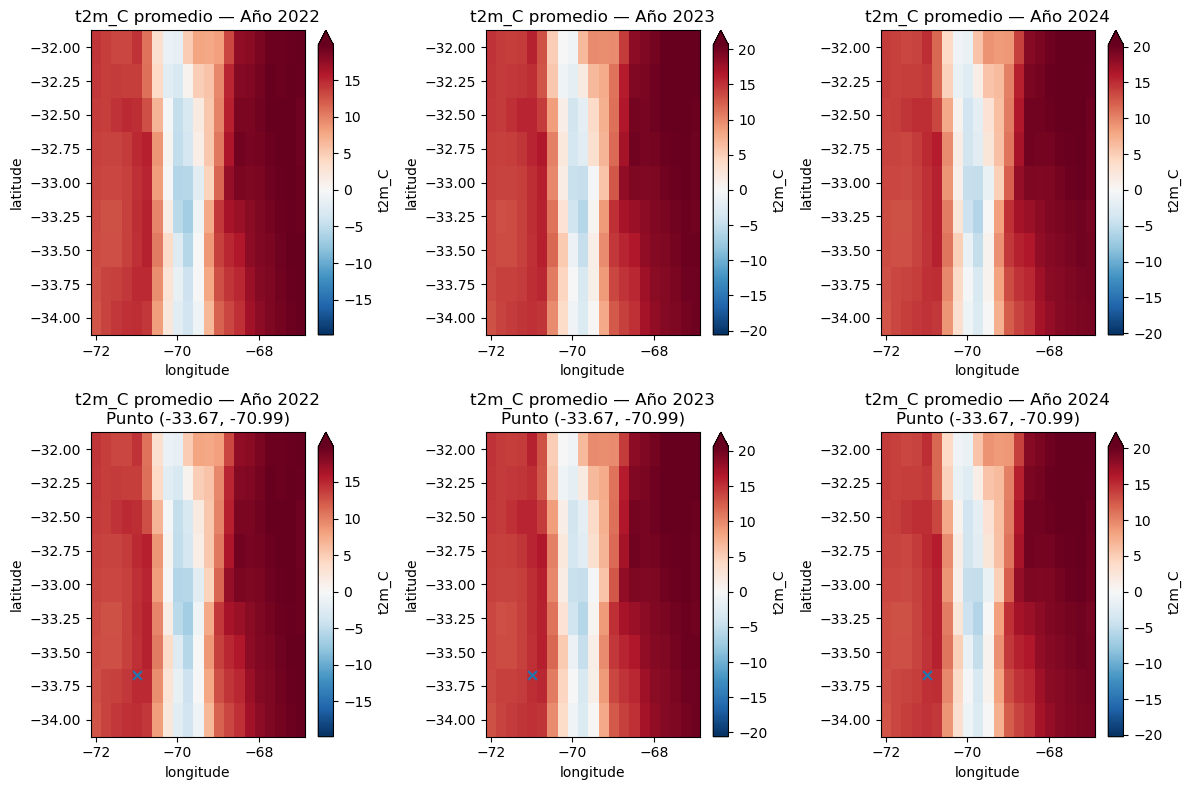

In [31]:
var = _pick_var(ds)
print(var)
da = _ensure_celsius(ds[var]).rename(var)
_assert_dims(da)

plot_mapas_promedio_por_anio(da, var, ds, punto_monte_interes)


In [73]:
list(ds.data_vars)


['t2m', 'swvl1', 't2m_C']

In [68]:
import numpy as np
from sklearn.mixture import GaussianMixture

def ajustar_mezcla_gaussiana_1d_fijo(data, n_componentes=2, random_state=0):
    """
    Ajusta una mezcla gaussiana 1D con un número fijo de componentes.

    Parámetros
    ----------
    data : array-like
        Muestra 1D (se eliminan NaN).
    n_componentes : int
        Número fijo de gaussianas a ajustar.
    random_state : int
        Semilla para reproducibilidad.

    Devuelve
    --------
    model : GaussianMixture
        Modelo ajustado con n_componentes gaussianas.
    """
    x = np.asarray(data).ravel()
    x = x[~np.isnan(x)]

    if x.size == 0:
        return None

    X = x.reshape(-1, 1)

    model = GaussianMixture(
        n_components=n_componentes,
        covariance_type="full",
        random_state=random_state
    )

    model.fit(X)
    return model


def plot_histogramas_por_anio(da, var, ds, punto_interes, n=1, nbins = 100):
    """
    Genera una figura de 2 filas x (n_years+1) columnas:
    - Columna 0:
        Fila 1: histograma del campo completo (todos los años)
        Fila 2: histograma del punto de interés (todos los años) + mixture(n)
    - Columnas 1..n_years:
        Fila 1: histograma del campo completo por año
        Fila 2: histograma del punto de interés por año + mixture(n)

    Devuelve:
    - medias_mix: medias del mixture TOTAL (todos los años)
    - desvs_mix : desviaciones del mixture TOTAL (todos los años)
    """

    # Coordenadas
    lat_name = "latitude" if "latitude" in ds.coords else "lat"
    lon_name = "longitude" if "longitude" in ds.coords else "lon"

    lat_min = float(ds[lat_name].min())
    lat_max = float(ds[lat_name].max())
    lon_min = float(ds[lon_name].min())
    lon_max = float(ds[lon_name].max())

    # Años
    years = np.unique(da["time"].dt.year.values)
    years_sorted = np.sort(years)          # para las columnas del plot (ascendente)
    n_years = len(years_sorted)

    # Punto de interés
    lat_p, lon_p = punto_interes
    punto_da = da.sel({lat_name: lat_p, lon_name: lon_p}, method="nearest")

    # Figura: +1 columna para "todos los años"
    n_cols = n_years + 1
    fig, axes = plt.subplots(2, n_cols, figsize=(4 * n_cols, 8), squeeze=False)

    titulo_global = (
        f"Histograma de {var} — "
        f"Lat [{lat_min:.2f}, {lat_max:.2f}] • "
        f"Lon [{lon_min:.2f}, {lon_max:.2f}]"
    )

    # ------------------------------------------------------------------
    # Columna 0: TODOS LOS AÑOS
    # ------------------------------------------------------------------
    # Campo completo (todos los tiempos)
    ax_top_all = axes[0, 0]
    da.plot.hist(ax=ax_top_all, bins=nbins)
    ax_top_all.set_title(f"{titulo_global}\nTodos los años")
    ax_top_all.set_xlabel(f"{var} ({da.attrs.get('units','')})")
    ax_top_all.set_ylabel("Frecuencia")

    # Punto de interés (todos los años)
    ax_bottom_all = axes[1, 0]
    datos_all = np.asarray(punto_da.values).ravel()
    datos_all = datos_all[~np.isnan(datos_all)]

    model_all = None  # <-- IMPORTANTE: para devolverlo después

    if datos_all.size > 0:
        counts_all, bin_edges_all, _ = ax_bottom_all.hist(datos_all, bins=nbins, alpha=0.7)
        ax_bottom_all.set_title(f"Punto ({lat_p:.2f}, {lon_p:.2f}) — Todos los años")
        ax_bottom_all.set_xlabel(f"{var} ({da.attrs.get('units','')})")
        ax_bottom_all.set_ylabel("Frecuencia")

        # Ajuste mixture(n) para todos los años
        model_all = ajustar_mezcla_gaussiana_1d_fijo(datos_all, n_componentes=n)
        if model_all is not None:
            x_min_all, x_max_all = datos_all.min(), datos_all.max()
            xs_all = np.linspace(x_min_all, x_max_all, 300)
            Xs_all = xs_all.reshape(-1, 1)

            bin_width_all = bin_edges_all[1] - bin_edges_all[0]
            scale_all = datos_all.size * bin_width_all

            log_pdf_all = model_all.score_samples(Xs_all)
            pdf_total_all = np.exp(log_pdf_all) * scale_all
            ax_bottom_all.plot(xs_all, pdf_total_all, label=f"Mixture K={n}")

            weights_all = model_all.weights_
            means_all = model_all.means_.ravel()
            stds_all  = np.sqrt(model_all.covariances_.reshape(-1))

            for k in range(n):
                mu = means_all[k]
                sigma = stds_all[k]
                w = weights_all[k]
                comp_pdf_all = (
                    w
                    * (1.0 / (np.sqrt(2 * np.pi) * sigma))
                    * np.exp(-0.5 * ((xs_all - mu) / sigma) ** 2)
                ) * scale_all
                ax_bottom_all.plot(
                    xs_all, comp_pdf_all, linestyle="--", alpha=0.9,
                    label=f"Comp {k+1}: μ={mu:.2f}, σ={sigma:.2f}"
                )

            ax_bottom_all.legend(fontsize=8)

    else:
        ax_bottom_all.set_title(f"Punto ({lat_p:.2f}, {lon_p:.2f}) — Todos los años (sin datos)")

    # ------------------------------------------------------------------
    # Columnas 1..n_years: año a año (solo visualización)
    # ------------------------------------------------------------------
    for idx, year in enumerate(years_sorted):
        col = idx + 1

        # Campo completo en el año
        da_year = da.sel(time=str(year))
        ax_top = axes[0, col]

        da_year.plot.hist(ax=ax_top, bins=nbins)
        ax_top.set_title(f"Año {year}")
        ax_top.set_xlabel(f"{var} ({da.attrs.get('units','')})")
        ax_top.set_ylabel("Frecuencia")

        # Punto de interés en el año
        punto_year = punto_da.sel(time=str(year))
        ax_bottom = axes[1, col]

        datos = np.asarray(punto_year.values).ravel()
        datos = datos[~np.isnan(datos)]

        if datos.size == 0:
            ax_bottom.set_title(
                f"Punto ({lat_p:.2f}, {lon_p:.2f}) — Año {year} (sin datos)"
            )
            ax_bottom.set_xlabel(f"{var} ({da.attrs.get('units','')})")
            ax_bottom.set_ylabel("Frecuencia")
            continue

        counts, bin_edges, _ = ax_bottom.hist(datos, bins=nbins, alpha=0.7)
        ax_bottom.set_title(f"Punto ({lat_p:.2f}, {lon_p:.2f}) — Año {year}")
        ax_bottom.set_xlabel(f"{var} ({da.attrs.get('units','')})")
        ax_bottom.set_ylabel("Frecuencia")

        # Mixture(n) en ese año (solo plot)
        model = ajustar_mezcla_gaussiana_1d_fijo(datos, n_componentes=n)
        if model is None:
            continue

        x_min, x_max = datos.min(), datos.max()
        xs = np.linspace(x_min, x_max, 300)
        Xs = xs.reshape(-1, 1)

        bin_width = bin_edges[1] - bin_edges[0]
        scale = datos.size * bin_width

        log_pdf = model.score_samples(Xs)
        pdf_total = np.exp(log_pdf) * scale
        ax_bottom.plot(xs, pdf_total, label=f"Mixture K={n}")

        weights = model.weights_
        means = model.means_.ravel()
        stds = np.sqrt(model.covariances_.reshape(-1))

        for k in range(n):
            mu = means[k]
            sigma = stds[k]
            w = weights[k]
            comp_pdf = (
                w
                * (1.0 / (np.sqrt(2 * np.pi) * sigma))
                * np.exp(-0.5 * ((xs - mu) / sigma) ** 2)
            ) * scale
            ax_bottom.plot(
                xs, comp_pdf, linestyle="--", alpha=0.9,
                label=f"Comp {k+1}: μ={mu:.2f}, σ={sigma:.2f}"
            )

        ax_bottom.legend(fontsize=8)

    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------------------
    # DEVOLVER SOLO LAS MEDIAS Y DEVS DEL MIXTURE TOTAL
    # ------------------------------------------------------------------
    if model_all is not None:
        medias_mix = model_all.means_.ravel()
        desvs_mix  = np.sqrt(model_all.covariances_.reshape(-1))
    else:
        medias_mix = np.array([np.nan])
        desvs_mix  = np.array([np.nan])

    return medias_mix, desvs_mix




def evaluar_mezclas_gaussianas_1d(data, max_components=5, bins=50, random_state=0):
    """
    Evalúa mezclas gaussianas 1D para K = 1..max_components.

    Parámetros
    ----------
    data : array-like
        Datos 1D (se eliminan NaN).
    max_components : int
        Nº máximo de gaussianas a evaluar.
    bins : int
        Nº de bins para el histograma (solo para el RMSE frente al histograma).
    random_state : int
        Semilla para reproducibilidad.

    Devuelve
    --------
    resultados : list of dict
        Lista de diccionarios, uno por K, con claves:
        - 'K'           : nº de componentes
        - 'loglik'      : log-verosimilitud total
        - 'loglik_med'  : log-verosimilitud media por dato
        - 'AIC'
        - 'BIC'
        - 'rmse_hist'   : RMSE entre densidad empírica (hist) y densidad del modelo
    """
    x = np.asarray(data).ravel()
    x = x[~np.isnan(x)]

    resultados = []
    if x.size == 0:
        return resultados

    X = x.reshape(-1, 1)

    # Histograma empírico (densidad)
    counts, bin_edges = np.histogram(x, bins=bins, density=True)
    x_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    Xc = x_centers.reshape(-1, 1)

    for K in range(1, max_components + 1):
        gm = GaussianMixture(
            n_components=K,
            covariance_type="full",
            random_state=random_state
        )
        gm.fit(X)

        # log-verosimilitud total y media
        loglik_med = gm.score(X)           # loglik/n
        loglik_tot = loglik_med * x.size

        # AIC y BIC incorporan penalización por complejidad
        aic = gm.aic(X)
        bic = gm.bic(X)

        # Densidad del modelo en los centros del histograma
        log_pdf_model = gm.score_samples(Xc)
        pdf_model = np.exp(log_pdf_model)

        # RMSE entre densidad empírica y modelo
        rmse = np.sqrt(np.mean((counts - pdf_model) ** 2))

        resultados.append({
            "K": K,
            "loglik": loglik_tot,
            "loglik_med": loglik_med,
            "AIC": aic,
            "BIC": bic,
            "rmse_hist": rmse,
        })

    return resultados




In [ ]:
import numpy as np
from sklearn.mixture import GaussianMixture

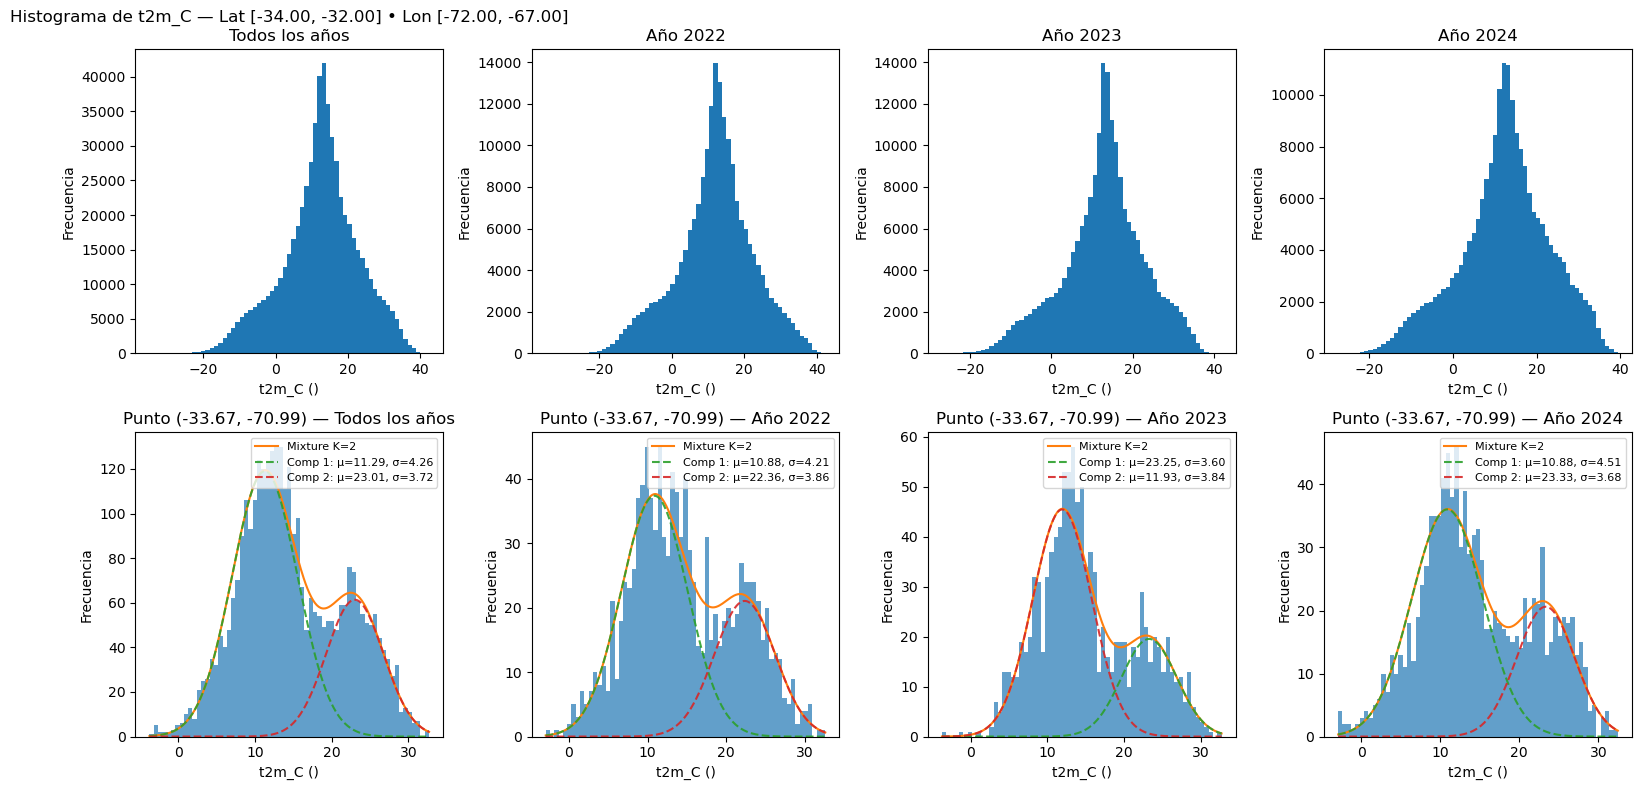


--- SIGNIFICADO DE LOS INDICADORES DE AJUSTE ---
K : número de gaussianas en la mezcla.
loglik : log-verosimilitud total del modelo (más alto = mejor).
loglik_med : log-verosimilitud media por dato (más alto = mejor).
AIC : Akaike Information Criterion (más bajo = mejor). Penaliza complejidad moderadamente.
BIC : Bayesian Information Criterion (más bajo = mejor). Penaliza complejidad fuertemente.
rmse_hist : error respecto al histograma (más bajo = mejor), pero depende del número de bins.

--- RANGOS RAZONABLES ---
loglik_med : suele estar entre -10 y 0 para datos reales. Más cercano a 0 = mejor.
AIC/BIC : solo se comparan entre modelos, su valor absoluto NO importa.
Diferencias BIC de ~10 puntos indican mejora real. Diferencias < 2 son irrelevantes.
rmse_hist : depende de los bins, no tiene rango universal. Úsalo solo como referencia.

--- RESULTADOS DEL AJUSTE (K=1..5) ---
{'K': 1, 'loglik': np.float32(-3579.6924), 'loglik_med': np.float32(-3.2691255), 'AIC': np.float32(7163.385), '

In [69]:
med, dev = plot_histogramas_por_anio(da, var, ds, punto_monte_interes, n = 2,nbins = 65 )


lat_p, lon_p = punto_monte_interes

# Elige cómo se llaman las coordenadas en tu Dataset:
lat_name = "latitude" if "latitude" in ds.coords else "lat"
lon_name = "longitude" if "longitude" in ds.coords else "lon"

# --- 2. Obtener la serie temporal del punto ---
punto_da = da.sel({lat_name: lat_p, lon_name: lon_p}, method="nearest")

# --- 3. Seleccionar un año específico ---
datos = np.asarray(punto_da.sel(time=str(2023)).values).ravel()
datos = datos[~np.isnan(datos)]   # limpiar NaNs

# --- 4. Evaluar modelos mixture K=1..5 ---
res = evaluar_mezclas_gaussianas_1d(datos, max_components=5)

# --- 5. Explicación de los indicadores ---
print("\n--- SIGNIFICADO DE LOS INDICADORES DE AJUSTE ---")
print("K : número de gaussianas en la mezcla.")
print("loglik : log-verosimilitud total del modelo (más alto = mejor).")
print("loglik_med : log-verosimilitud media por dato (más alto = mejor).")
print("AIC : Akaike Information Criterion (más bajo = mejor). Penaliza complejidad moderadamente.")
print("BIC : Bayesian Information Criterion (más bajo = mejor). Penaliza complejidad fuertemente.")
print("rmse_hist : error respecto al histograma (más bajo = mejor), pero depende del número de bins.\n")

print("--- RANGOS RAZONABLES ---")
print("loglik_med : suele estar entre -10 y 0 para datos reales. Más cercano a 0 = mejor.")
print("AIC/BIC : solo se comparan entre modelos, su valor absoluto NO importa.")
print("Diferencias BIC de ~10 puntos indican mejora real. Diferencias < 2 son irrelevantes.")
print("rmse_hist : depende de los bins, no tiene rango universal. Úsalo solo como referencia.\n")

# --- 6. Resultados ---
print("--- RESULTADOS DEL AJUSTE (K=1..5) ---")
for r in res:
    print(r)



In [70]:
import numpy as np

def separar_ds_por_gaussianas(ds, da, punto_interes, n=2):
    """
    Separa el Dataset original en ds1 y ds2 según el régimen
    asignado por un GaussianMixture(n) ajustado a la serie del punto de interés.

    - ds1: tiempos donde el punto cae en componente 0
    - ds2: tiempos donde el punto cae en componente 1
    (si n>2, habrá más componentes, pero aquí devolvemos solo un dict)

    Devuelve:
    - ds_por_comp: dict {k: ds_k} con un Dataset por componente
    - labels: array de etiquetas para cada tiempo válido (sin NaNs) del punto
    """
    from sklearn.mixture import GaussianMixture

    # Coordenadas
    lat_name = "latitude" if "latitude" in ds.coords else "lat"
    lon_name = "longitude" if "longitude" in ds.coords else "lon"

    lat_p, lon_p = punto_interes

    # Serie temporal en el punto
    punto_da = da.sel({lat_name: lat_p, lon_name: lon_p}, method="nearest")

    # Valores y máscara de NaNs
    vals = np.asarray(punto_da.values).ravel()
    mask = ~np.isnan(vals)

    if mask.sum() == 0:
        raise ValueError("No hay datos válidos (no-NaN) en el punto de interés.")

    vals_valid = vals[mask]
    X = vals_valid.reshape(-1, 1)

    # Ajuste del mixture (mismo n que usas en los histogramas)
    gm = GaussianMixture(
        n_components=n,
        covariance_type="full",
        random_state=0
    )
    gm.fit(X)

    # Etiquetas de componente para cada observación válida
    labels = gm.predict(X)          # enteros 0..n-1

    # Tiempos correspondientes solo a los datos válidos
    tiempos = punto_da["time"].values[mask]

    # Construir un Dataset por componente
    ds_por_comp = {}
    for k in range(n):
        tiempos_k = tiempos[labels == k]
        ds_por_comp[k] = ds.sel(time=tiempos_k)

    return ds_por_comp, labels


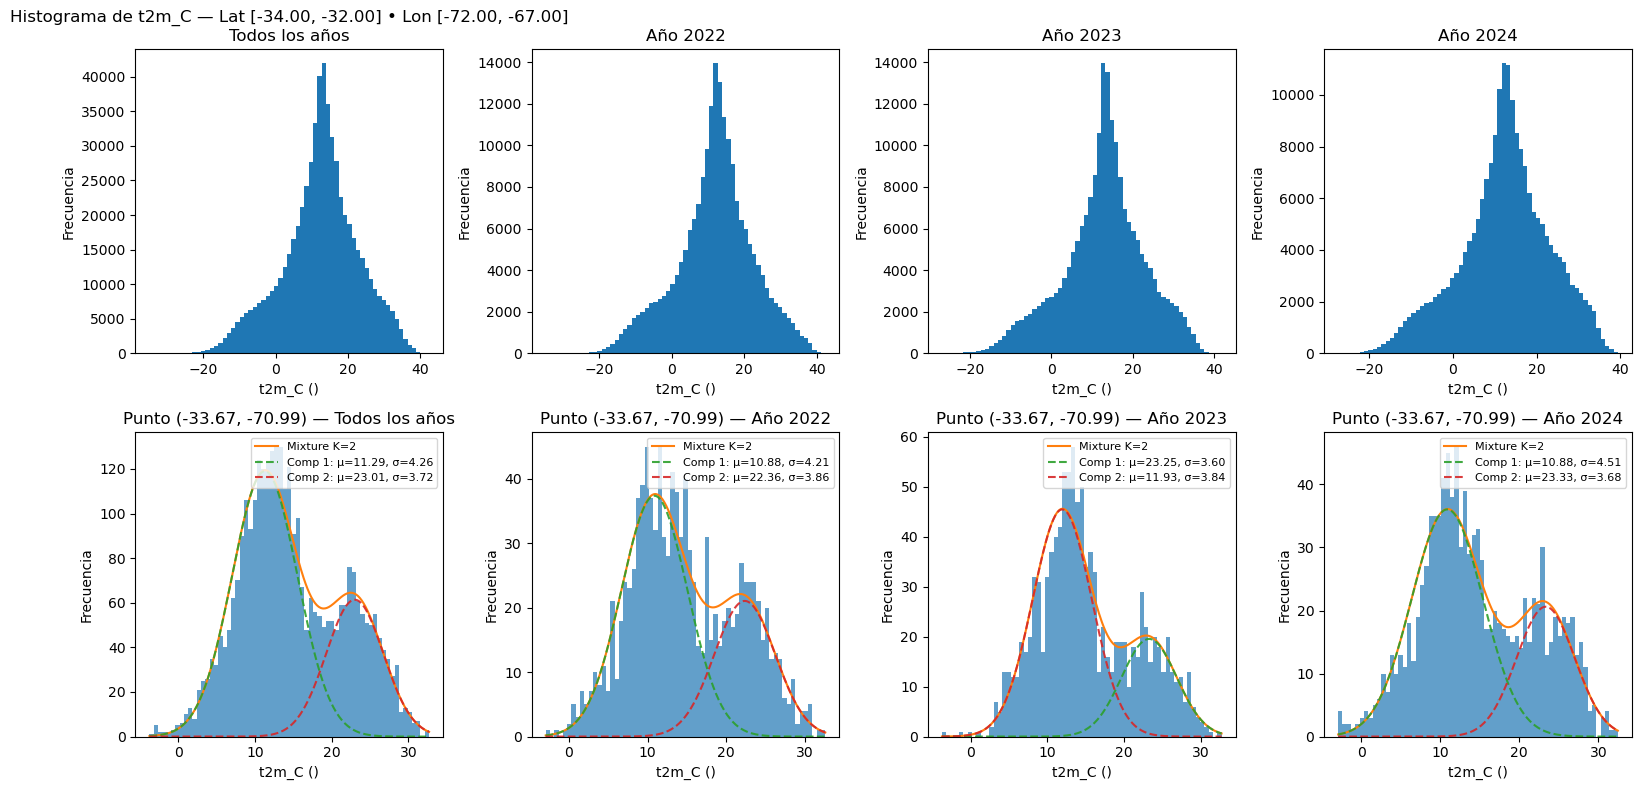

In [71]:
# 1) Haces tus gráficos y obtienes μ, σ (para información)
med, dev = plot_histogramas_por_anio(da, var, ds, punto_monte_interes, n=2, nbins=65)

# 2) Separas el dataset en regímenes según el mixture
ds_por_comp, labels = separar_ds_por_gaussianas(ds, da, punto_monte_interes, n=2)

ds1 = ds_por_comp[0]
ds2 = ds_por_comp[1]


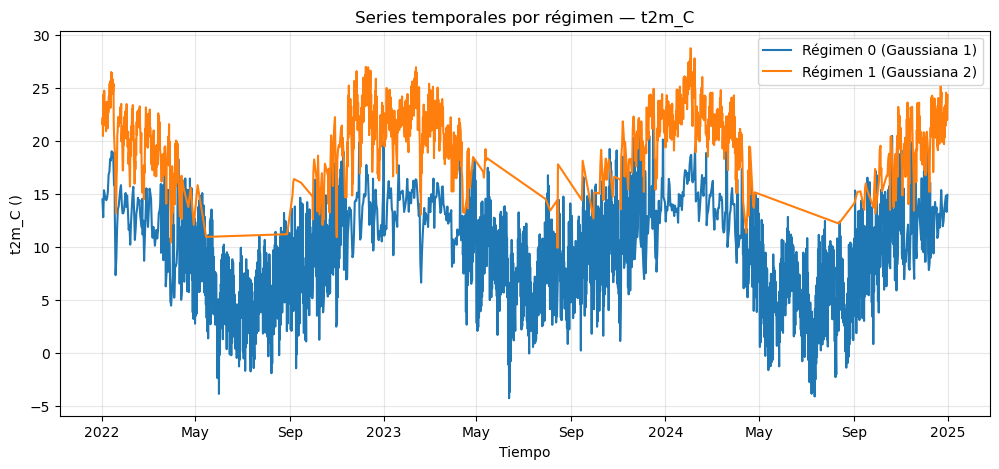

In [72]:
# Serie temporal 1 (régimen 0)
ts1 = ds1[var].mean(dim=("latitude","longitude"))

# Serie temporal 2 (régimen 1)
ts2 = ds2[var].mean(dim=("latitude","longitude"))

plt.figure(figsize=(12,5))

ts1.plot(label="Régimen 0 (Gaussiana 1)")
ts2.plot(label="Régimen 1 (Gaussiana 2)")

plt.title(f"Series temporales por régimen — {var}")
plt.xlabel("Tiempo")
plt.ylabel(f"{var} ({da.attrs.get('units','')})")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


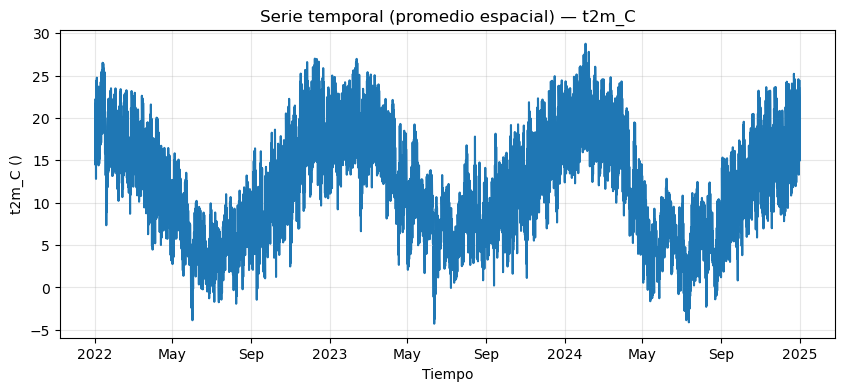

In [19]:
ts = da.mean(dim=("latitude","longitude"))

plt.figure(figsize=(10,4))
ts.plot()
plt.title(f"Serie temporal (promedio espacial) — {var}")
plt.xlabel("Tiempo")
plt.ylabel(f"{var} ({da.attrs.get('units','')})")
plt.grid(True, alpha=0.3)
plt.show()


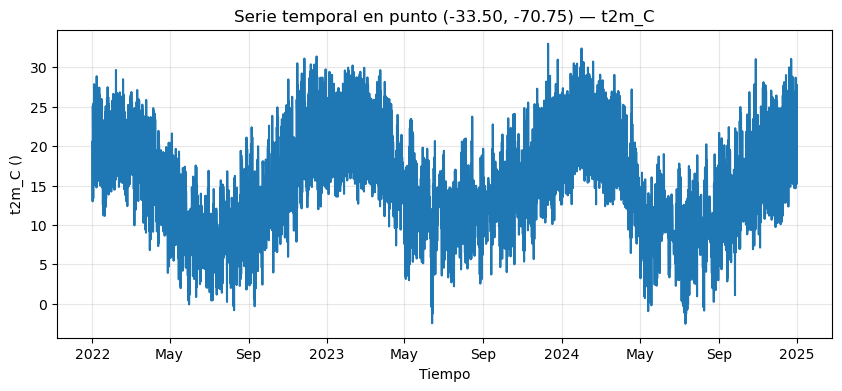

In [20]:
lat_name, lon_name, latv, lonv = _pick_point_coords(ds)

ts_point = da.sel({lat_name: latv, lon_name: lonv}, method="nearest")

plt.figure(figsize=(10,4))
ts_point.plot()
plt.title(f"Serie temporal en punto ({latv:.2f}, {lonv:.2f}) — {var}")
plt.xlabel("Tiempo")
plt.ylabel(f"{var} ({da.attrs.get('units','')})")
plt.grid(True, alpha=0.3)
plt.show()


Shape of clim_m[da_crudo.name]: (12, 9, 21)
Content of clim_m[da_crudo.name]: <xarray.DataArray 't2m_C' (month: 12, latitude: 9, longitude: 21)> Size: 9kB
dask.array<concatenate, shape=(12, 9, 21), dtype=float32, chunksize=(1, 9, 21), chunktype=numpy.ndarray>
Coordinates:
  * month      (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * latitude   (latitude) float64 72B -34.0 -33.75 -33.5 ... -32.5 -32.25 -32.0
  * longitude  (longitude) float64 168B -72.0 -71.75 -71.5 ... -67.25 -67.0
    number     (month) int64 96B 0 0 0 0 0 0 0 0 0 0 0 0


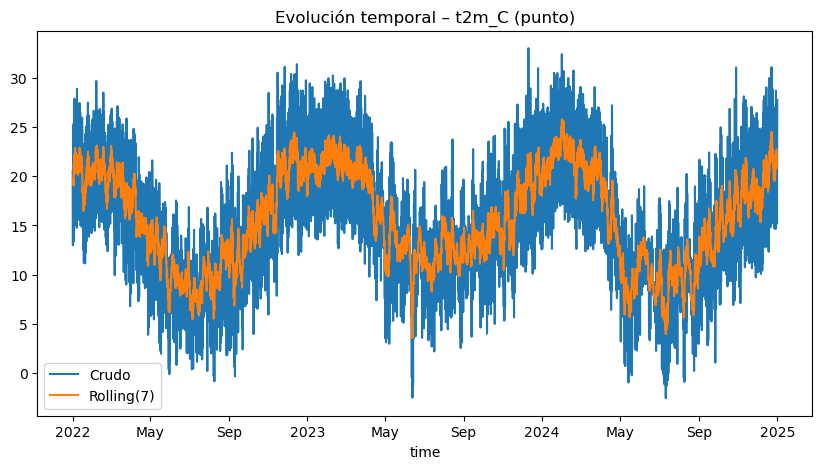

In [36]:
# Mensual
ds_mensual = ds.resample(time="1MS").mean() # TODO: comparar estadisticas por dia / mes

# Media estacional (DJF/MAM/JJA/SON)
ds_est = ds.groupby("time.season").mean()

# Rolling/ventanas móviles (p.ej. 7 días)
roll = ds.rolling(time=7, center=True).mean()

# Anomalías respecto a climatología mensual  (ajusta el rango)
base = ds.sel(time=slice(ds.time.min(), ds.time.max()))
clim_m = base.groupby("time.month").mean()
anom = ds.groupby("time.month") - clim_m

# Desviación estándar temporal (por celda)
std_t = ds.std(dim="time")

# Variables derivadas ya existen: roll (Dataset), anom (Dataset), clim_m (Dataset)
da_crudo = _ensure_celsius(ds[_pick_var(ds)])
_assert_dims(da_crudo)

# Climatología mensual “en el punto” (media de cada mes)
# Add print statements to diagnose the error
print("Shape of clim_m[da_crudo.name]:", clim_m[da_crudo.name].shape)
print("Content of clim_m[da_crudo.name]:", clim_m[da_crudo.name])

roll_px = roll[da_crudo.name].sel({lat_name: latv, lon_name: lonv}, method="nearest")

# Serie comparativa
fig = plt.figure(figsize=(10,5))
da_crudo.sel({lat_name: latv, lon_name: lonv}, method="nearest").plot(label="Crudo")
roll_px.plot(label="Rolling(7)")
plt.legend()
plt.title(f"Evolución temporal – {da_crudo.name} (punto)")
plt.xlabel("time"); plt.ylabel(da_crudo.attrs.get("units",""))
plt.show()


### Cosas de verdad